In [ ]:
from google.colab import drive

# Montage du lecteur Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Taches Preliminaires

In [ ]:
def load_sequences_from_folder(folder, target_size,num_frames):
    filenames = sorted(os.listdir(folder))
    selected_filenames = filenames[-num_frames:]
    sequence = []
    for filename in selected_filenames:
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        sequence.append(img_array)
    return np.array(sequence)


In [ ]:
def pad_sequence(sequence, max_length):
    current_length = sequence.shape[0]
    if current_length < max_length:
        padding = np.zeros((max_length - current_length, *sequence.shape[1:]))
        sequence = np.vstack((sequence, padding))
    return sequence

In [ ]:
# def load_dataset(data_dir, num_videos=100,target_size=(128, 128)):
#     input_sequences = []
#     target_sequences = []
#     video_folders = sorted(os.listdir(data_dir))[:num_videos]  # Limit to first 314 folders
#     for video_folder in video_folders:
#         input_frames_dir = os.path.join(data_dir, video_folder, 'input_frames')
#         target_frame_dir = os.path.join(data_dir, video_folder, 'target_frames')

#         try:
#             input_sequence = load_sequences_from_folder(input_frames_dir, target_size)
#             target_sequence = load_sequences_from_folder(target_frame_dir, target_size)
#             input_sequences.append(input_sequence)
#             target_sequences.append(target_sequence)
#         except FileNotFoundError as e:
#             print(f"Skipping folder {video_folder} due to missing files: {e}")

#     return input_sequences, target_sequences



def load_dataset(data_dir, num_videos=171,target_size=(128, 128),num2=300):
    input_sequences = []
    target_sequences = []
    video_folders = sorted(os.listdir(data_dir))[:num2]

    for video_folder in video_folders:
        input_frames_dir = os.path.join(data_dir, video_folder, 'input_frames')
        target_frame_dir = os.path.join(data_dir, video_folder, 'target_frames')

        input_sequence = load_sequences_from_folder(input_frames_dir, target_size,num_frames=59)
        target_sequence = load_sequences_from_folder(target_frame_dir, target_size,num_frames=59)

        input_sequences.append(input_sequence)
        target_sequences.append(target_sequence)

    return np.array(input_sequences), np.array(target_sequences)

In [ ]:
# Chargement Des Images

In [ ]:
# Chemin vers le dossier de données
DATASET_DIR = "/content/drive/MyDrive/motion-raw-video/data/dataset_motion_6s_pred"

TARGET_SIZE = (128, 128)

# Charger les images
input_sequences, target_sequences = load_dataset(DATASET_DIR,num_videos=171 ,target_size=TARGET_SIZE,num2=300)

# Normaliser les images
input_sequences = [seq.astype('float32') / 255.0 for seq in input_sequences]
target_sequences = [seq.astype('float32') / 255.0 for seq in target_sequences]

print(f'Loaded {len(input_sequences)} input sequences and {len(target_sequences)} target sequences.')

In [ ]:
  target_sequences[0].shape

(59, 128, 128, 3)

In [ ]:
# physical_devices = tf.config.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)
#     tf.config.experimental.set_virtual_device_configuration(
#         physical_devices[0],
#         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
#     )

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, TimeDistributed, ConvLSTM2D

# Dimensions des images
img_height, img_width, img_channels = 128, 128, 3

# Création du modèle
def create_model(input_shape):
    # Encodeur
    encoder_inputs = Input(shape=input_shape)
    encoded_seq = TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'))(encoder_inputs)
    encoded_seq = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(encoded_seq)
    encoded_seq = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(encoded_seq)
    encoded_seq = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(encoded_seq)

    # LSTM pour encoder la séquence
    encoded_seq = ConvLSTM2D(32, (3, 3), activation='relu', padding='same', return_sequences=True)(encoded_seq)

    # Décodeur
    decoded_seq = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(encoded_seq)
    decoded_seq = TimeDistributed(UpSampling2D((2, 2)))(decoded_seq)
    decoded_seq = TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'))(decoded_seq)
    decoded_seq = TimeDistributed(UpSampling2D((2, 2)))(decoded_seq)
    decoded_seq = TimeDistributed(Conv2D(img_channels, (3, 3), activation='sigmoid', padding='same'))(decoded_seq)

    # Création du modèle
    model = Model(encoder_inputs, decoded_seq)

    # Compilation du modèle
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Exemple d'utilisation
input_shape = (None, img_height, img_width, img_channels)  # Séquences de longueur variable
model = create_model(input_shape)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 128, 128,   0         
                              3)]                                
                                                                 
 time_distributed (TimeDist  (None, None, 128, 128,    448       
 ributed)                    16)                                 
                                                                 
 time_distributed_1 (TimeDi  (None, None, 64, 64, 16   0         
 stributed)                  )                                   
                                                                 
 time_distributed_2 (TimeDi  (None, None, 64, 64, 32   4640      
 stributed)                  )                                   
                                                                 
 time_distributed_3 (TimeDi  (None, None, 32, 32, 32   0     

In [ ]:
np.savez('/content/drive/MyDrive/motion-raw-video/data/final.npz',input=input_sequences,target =target_sequences)

In [ ]:
# Paramètres d'entraînement
batch_size = 50  # Taille du batch pour les séquences de longueur variable
epochs = 100

# Fonction de générateur pour les séquences
def sequence_generator(input_sequences, target_sequences, batch_size):
    while True:
        for i in range(len(input_sequences)):
            input_seq = np.expand_dims(input_sequences[i], axis=0)
            target_seq = np.expand_dims(target_sequences[i], axis=0)
            yield input_seq, target_seq

# Créer le générateur de séquences
train_gen = sequence_generator(input_sequences, target_sequences, batch_size)

# Entraîner le modèle
history = model.fit(train_gen, steps_per_epoch=len(input_sequences), epochs=epochs)

Epoch 1/100
170/170 [==============================] - 542s 3s/step - loss: 0.0470
Epoch 2/100
170/170 [==============================] - 528s 3s/step - loss: 0.0385
Epoch 3/100
170/170 [==============================] - 539s 3s/step - loss: 0.0372
Epoch 4/100
170/170 [==============================] - 543s 3s/step - loss: 0.0364
Epoch 5/100
170/170 [==============================] - 525s 3s/step - loss: 0.0363
Epoch 6/100
170/170 [==============================] - 537s 3s/step - loss: 0.0357
Epoch 7/100
124/170 [====================>.........] - ETA: 2:24 - loss: 0.0323

In [ ]:
predictions = [model.predict(np.expand_dims(seq, axis=0))[0] for seq in input_sequences]

1/1 [==============================] - 0s 95ms/step


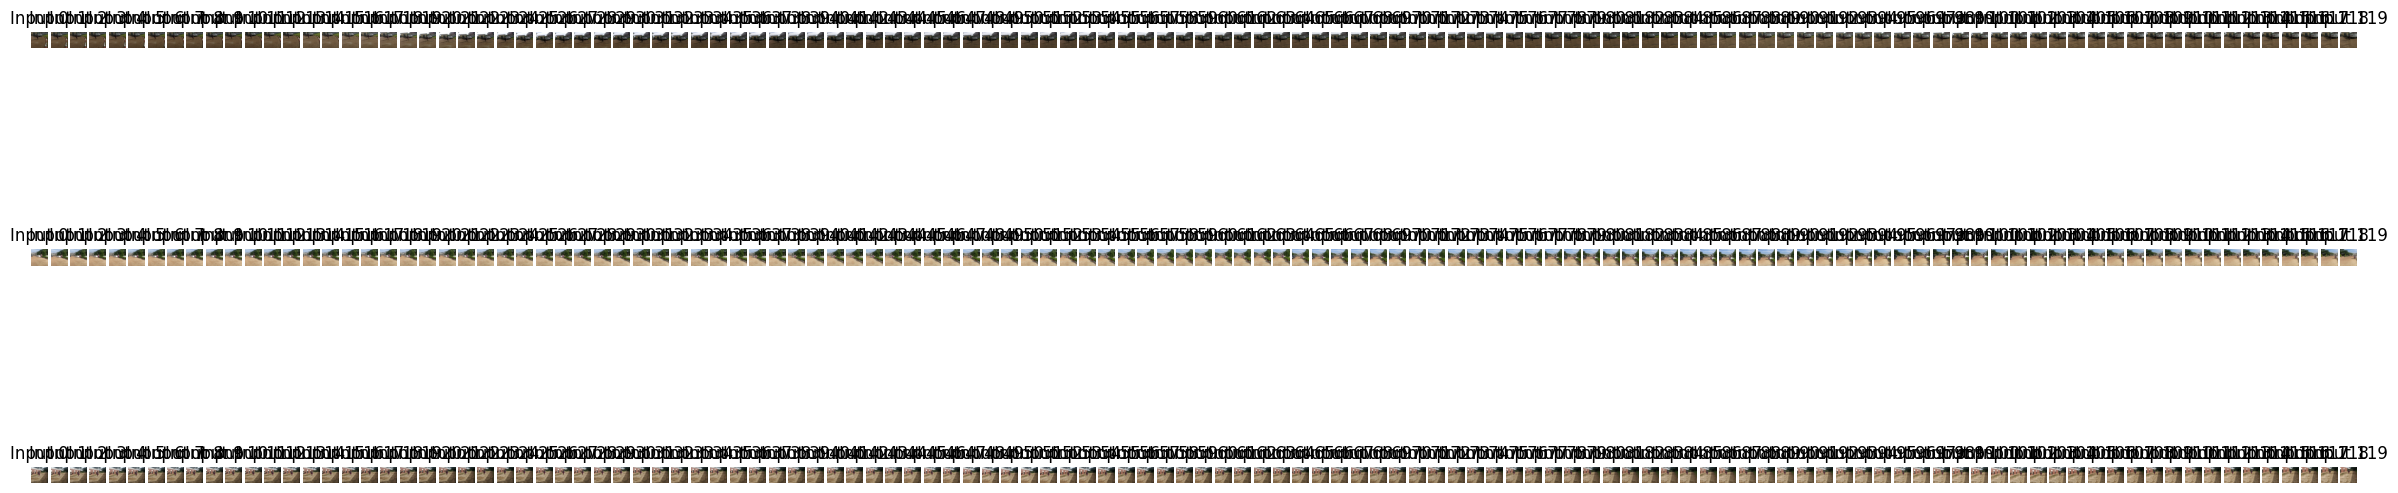

In [ ]:
import matplotlib.pyplot as plt

n = 3  # Nombre d'exemples à afficher
plt.figure(figsize=(30, 8))
for i in range(n):
    seq_len = len(input_sequences[i])
    # Séquence d'entrée
    for t in range(seq_len):
        ax = plt.subplot(3, seq_len, t + 1 + i * seq_len)
        plt.imshow(input_sequences[i][t])
        plt.title(f"Input {t}")
        plt.axis("off")
plt.show()

In [ ]:
  # Séquence de sortie prédite
    for t in range(seq_len):
        ax = plt.subplot(3, seq_len, t + 1 + (i + 1) * seq_len)
        plt.imshow(predictions[i][t])
        plt.title(f"Predicted {t}")
        plt.axis("off")


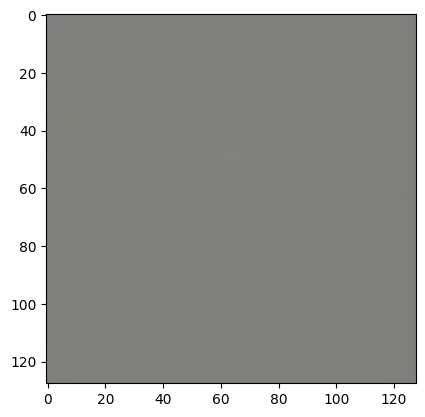

In [ ]:
plt.imshow(predictions[1][0])